# How good are zero error extrapolations as a function of noise scalings on H atoms at 0.74 ang  separation?

In [1]:
#set up noise model
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

import qiskit.providers.aer.noise as noise

# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.02   # 2-qubit gate

noise_models = []

n_scale = 10

for i in range(n_scale):
    #scaling probabilities 
    prob_1 = (i+1)*0.001
    prob_2 = (i+1)*0.01
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(prob_1, 1)
    error_2 = noise.depolarizing_error(prob_2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    noise_models.append(noise_model)

# Set up VQE
#Doing away with all libraries
from qiskit.aqua.algorithms import VQE, ExactEigensolver
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit import IBMQ
from qiskit.providers.aer import noise
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.aqua.operators import Z2Symmetries


from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

In [2]:
# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmqx2')
noise_model = NoiseModel.from_backend(backend)
qiskit.providers.aer.noise.device.gate_error_values(backend.properties())

[('id', [0], 0.0005774560429975218),
 ('u1', [0], 0),
 ('u2', [0], 0.0005774560429975218),
 ('u3', [0], 0.001154578630513492),
 ('id', [1], 0.0005108449876632691),
 ('u1', [1], 0),
 ('u2', [1], 0.0005108449876632691),
 ('u3', [1], 0.0010214290127251724),
 ('id', [2], 0.0007314305970285499),
 ('u1', [2], 0),
 ('u2', [2], 0.0007314305970285499),
 ('u3', [2], 0.0014623262033387485),
 ('id', [3], 0.0007876953848722151),
 ('u1', [3], 0),
 ('u2', [3], 0.0007876953848722151),
 ('u3', [3], 0.0015747703057250595),
 ('id', [4], 0.0005540288702334259),
 ('u1', [4], 0),
 ('u2', [4], 0.0005540288702334259),
 ('u3', [4], 0.001107750792477935),
 ('cx', [0, 1], 0.01652108394539878),
 ('cx', [0, 2], 0.015230825301136314),
 ('cx', [1, 0], 0.01652108394539878),
 ('cx', [1, 2], 0.022310562048605292),
 ('cx', [2, 0], 0.015230825301136314),
 ('cx', [2, 1], 0.022310562048605292),
 ('cx', [2, 3], 0.017442576632012763),
 ('cx', [2, 4], 0.015546294172546021),
 ('cx', [3, 2], 0.017442576632012763),
 ('cx', [3, 4

In [3]:
def get_qubit_ops(dist): 
    # Defining Molecule
    mol = 'H .0 .0 .0 ; H .0 .0 {}'
    driver = PySCFDriver(mol.format(dist), unit=UnitsType.ANGSTROM,
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    # Mapping to Qubit Hamiltonian
    map_type = 'parity'

    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    hf_energy = molecule.hf_energy 
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))
    # update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing

    # prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    qubitOp = ferOp.mapping(map_type=map_type, threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp.chop(10**-10)
    shift = energy_shift + repulsion_energy
    print(qubitOp)
    
    return qubitOp, num_particles, num_spin_orbitals, shift, hf_energy

In [4]:
#Begin VQE

#ignore warnings 
import warnings
warnings.filterwarnings("ignore")


import numpy as np
from qiskit import Aer
from qiskit.aqua.components.optimizers import COBYLA

# Specifying whether running code on a simulator or an actual quantum device
backend = Aer.get_backend("qasm_simulator")
# creating a list of distances to run VQE on 
distances = [0.74]
exact_energies = []
vqe_energies = []
vqe_ideal_energy = []
#adding empty boxes for later usage
for i in range(10): 
    vqe_energies.append([])

#Quantum Instances for each noise model 
quantum_instances = []
for noise_model in noise_models:
    quantum_instance = QuantumInstance(backend=backend, 
                                   noise_model=noise_model )
    quantum_instances.append(quantum_instance)

optimizer = COBYLA(maxiter=1000)
for i in range(100):
    for dist in distances:
        qubitOp, num_particles, num_spin_orbitals, shift, hf_energy = get_qubit_ops(dist)
        # Finding exact energies to show how off VQE was from exact energy curve
        result = ExactEigensolver(qubitOp).run()
        exact_energies.append(result['energy'] + shift)
        # Initial STate 
        initial_state = HartreeFock(
            num_spin_orbitals,
            num_particles,
            'parity'
        ) 
        print(qubitOp.num_qubits)
        # UCCSD Variational Form
        var_form = UCCSD(
            num_orbitals=num_spin_orbitals,
            num_particles=num_particles,
            initial_state=initial_state,
            qubit_mapping='parity'
        )
        # Running VQE using a simulator, not actual quantum computer
        vqe = VQE(qubitOp, var_form, optimizer)

        #Running Ideal VQE
        resulty = vqe.run(backend)['energy'] + shift
        vqe_ideal_energy.append(resulty)
        print('Number of evaluations are')
        print(vqe._eval_count)

        #running VQE for each noise scaling
        for k in range(10):
            results = vqe.run(quantum_instances[k])['energy'] + shift
            vqe_energies[k].append(results)
            print( str(k)+  " phase done")
        print(str(i+1) + ' samples dones' )
print("All energies have been calculated")

HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
1 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
2 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
37
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
3 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of e

Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
38
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
29 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
32
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
30 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
39
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
31 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
39
0 phase done
1 phase done
2 phase done
3 phase don

Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
57 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
37
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
58 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
40
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
59 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
39
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 ph

0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
85 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
39
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
86 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
34
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase done
87 samples dones
HF energy: -1.8318636464775064
# of electrons: 2
# of spin orbitals: 4
Representation: paulis, qubits: 2, size: 5
2
Number of evaluations are
37
0 phase done
1 phase done
2 phase done
3 phase done
4 phase done
5 phase done
6 phase done
7 phase done
8 phase done
9 phase

Text(0, 0.5, 'standard deviation/error (Hartree)')

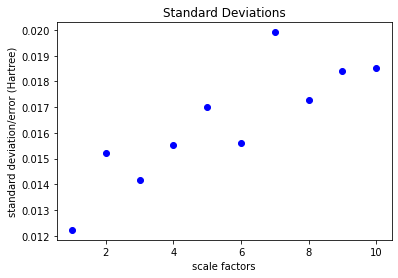

In [6]:
# Import the libraries
import matplotlib.pyplot as plt
#calculate standard deviations 
vqe_std = []
for i in range(10): 
    std = np.std(vqe_energies[i])
    vqe_std.append(std)
scales = [1,2,3,4,5,6,7,8,9,10]
plt.plot(scales, vqe_std, 'bo')
plt.title('Standard Deviations')
plt.xlabel('scale factors')
plt.ylabel('standard deviation (Hartree)')


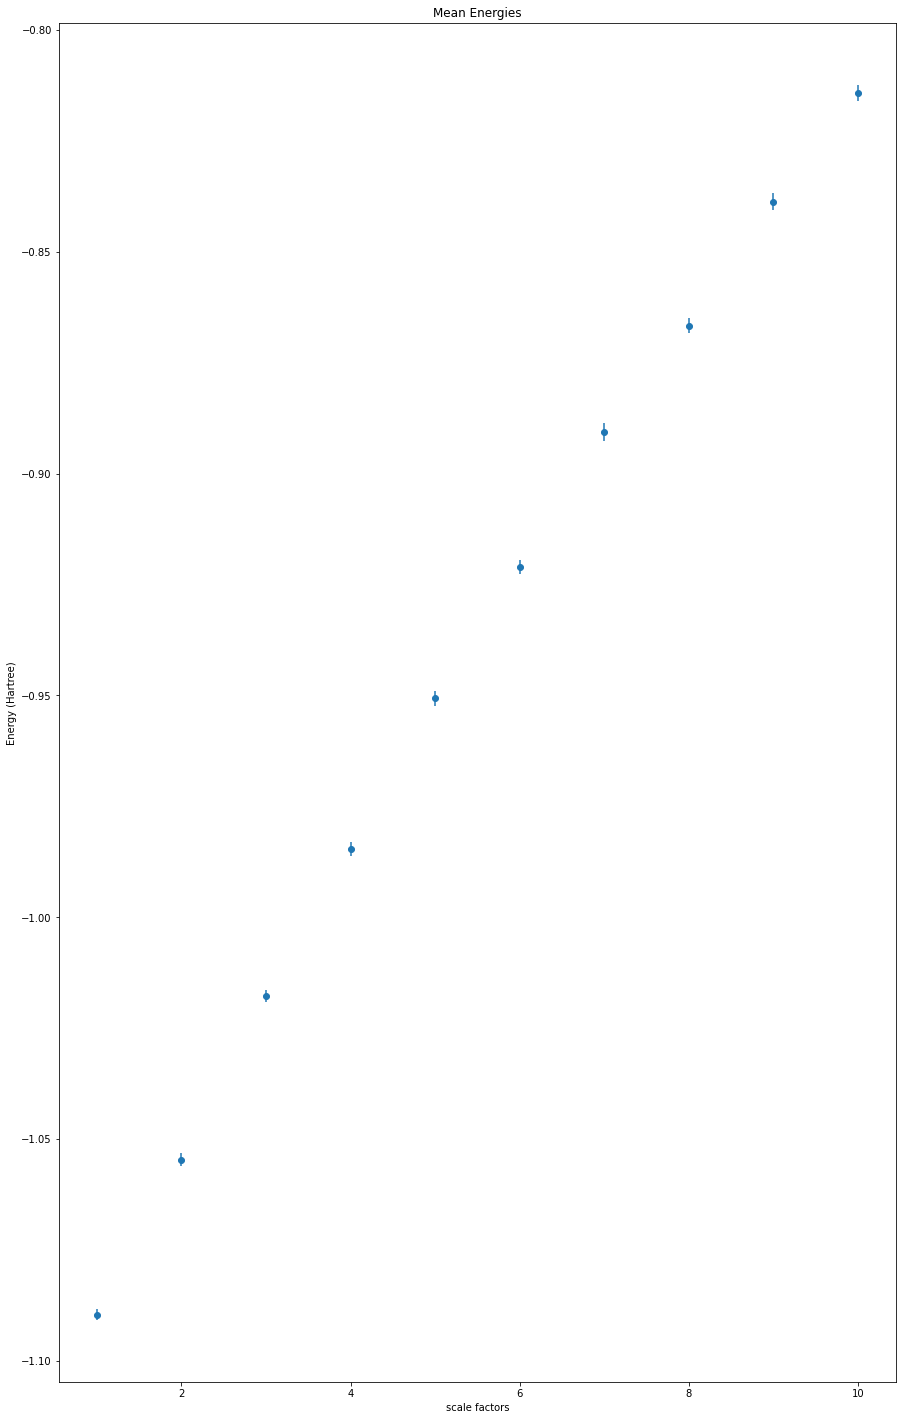

In [38]:
#calculate means and errors 
vqe_err  = [std/10 for std in vqe_std]
vqe_mean = []
for i in range(10): 
    mean = np.mean(vqe_energies[i])
    vqe_mean.append(mean)
scales = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(15,25))
plt.errorbar(scales, vqe_mean, yerr=vqe_err,fmt ='o' )

plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.show()

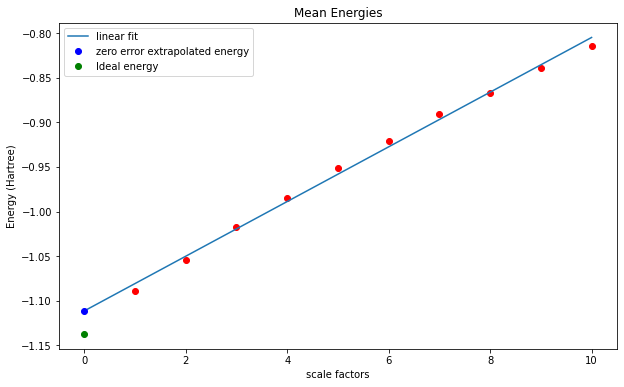

In [75]:
plt.figure(figsize=(10,6))
plt.plot(scales, vqe_mean, 'ro')
plt.plot([0] + scales, funcs[0]([0] + scales), label = 'linear fit')
plt.plot(0, funcs[0](0), 'bo', label = 'zero error extrapolated energy')
plt.plot(0, exact_energies[0], 'go', label = 'Ideal energy')
plt.title('Mean Energies')
plt.xlabel('scale factors')
plt.ylabel('Energy (Hartree)')
plt.legend()
plt.show()

In [7]:
# Import the libraries
import matplotlib.pyplot as plt

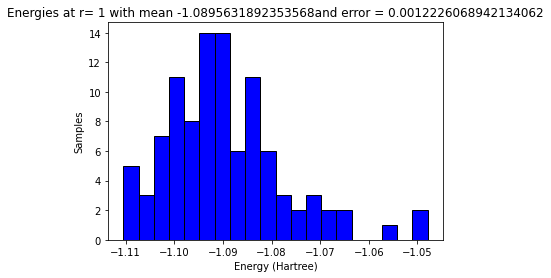

In [20]:
i = 0
# matplotlib histogram
plt.hist(vqe_energies[i], color = 'blue', edgecolor = 'black',
         bins = int(0.2/0.01))
plt.axvline(vqe_mean[i], 1, label='mean', color = 'k',linestyle = 'dashed', linewidth=1)
# Add labels
plt.title('Energies at r= '+ str(i+1) +' with mean ' + str(vqe_mean[i]) + 'and error = ' + str(vqe_err[i]))
plt.xlabel('Energy (Hartree)')
plt.ylabel('Samples')
plt.show()

### Curve Fitting

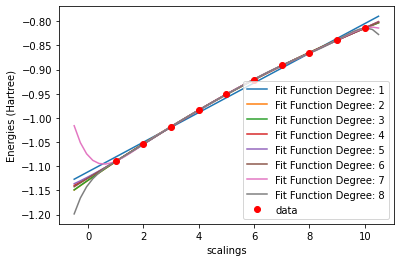

In [41]:
#Polynomial Curve Fitting (8th order)
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
scales = [1,2,3,4,5,6,7,8,9,10]
funcs = []
for i in range(1,9): 
    param = np.polyfit(scales, vqe_mean, i)
    p = np.poly1d(param)
    funcs.append(p)
x = np.linspace(-0.5, 10.5, 50)
for p in funcs: 
    plt.plot(x, p(x), label='Fit Function Degree: ' + str(p.order))
plt.plot(scales, vqe_mean, 'ro',label='data')
plt.xlabel('scalings')
plt.ylabel('Energies (Hartree)')
plt.legend()
plt.show()


In [22]:
exact_energies

[-1.1372838344885023,
 -1.1372838344885001,
 -1.1372838344885035,
 -1.1372838344885008,
 -1.1372838344884981,
 -1.1372838344885032,
 -1.1372838344885041,
 -1.137283834488501,
 -1.1372838344885,
 -1.1372838344885008,
 -1.1372838344885015,
 -1.1372838344885006,
 -1.1372838344885017,
 -1.137283834488501,
 -1.1372838344885035,
 -1.1372838344885023,
 -1.137283834488502,
 -1.1372838344885012,
 -1.1372838344885028,
 -1.1372838344885021,
 -1.1372838344885003,
 -1.1372838344885017,
 -1.137283834488501,
 -1.1372838344885017,
 -1.1372838344885008,
 -1.137283834488499,
 -1.1372838344885015,
 -1.1372838344885015,
 -1.1372838344884988,
 -1.137283834488501,
 -1.1372838344885001,
 -1.1372838344884995,
 -1.1372838344885008,
 -1.137283834488502,
 -1.1372838344885026,
 -1.1372838344884997,
 -1.1372838344885023,
 -1.1372838344885015,
 -1.137283834488501,
 -1.1372838344885021,
 -1.137283834488501,
 -1.1372838344885015,
 -1.1372838344885012,
 -1.1372838344885026,
 -1.1372838344884992,
 -1.1372838344885063,


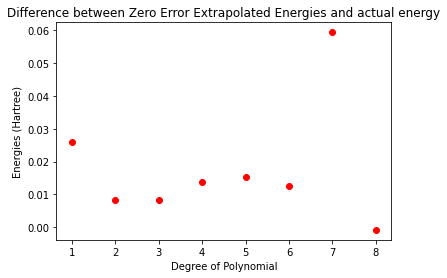

In [42]:
differences = []
for f in funcs: 
    differences.append(f(0) - np.mean(exact_energies))
plt.plot([1,2,3,4,5,6,7,8],differences, 
         'ro')
plt.title('Difference between Zero Error Extrapolated Energies and actual energy')
plt.plot()
plt.xlabel('Degree of Polynomial')
plt.ylabel('Energies (Hartree)')
plt.show()

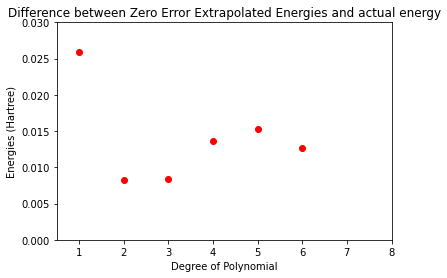

In [24]:
plt.plot([1,2,3,4,5,6,7,8],differences, 
         'ro')
plt.axis([0.5,8, 0.000, 0.03])
plt.title('Difference between Zero Error Extrapolated Energies and actual energy')
plt.plot()
plt.xlabel('Degree of Polynomial')
plt.ylabel('Energies (Hartree)')
plt.show()

In [25]:
#scaled chi square stats 
def chisq(arr_one , arr_two, arr_std, ddof): 
    chi_sq =0
    for i in range(len(arr_one)):
        chi_sq += (((arr_one[i]-arr_two[i])**2)/ (arr_std[i]**2))
    return (100*chi_sq)/ddof
for p in funcs:
    print("Chi Square Statistics for polynomial fit of degree " +str(p.order)+  ":" )
    print(str(chisq(vqe_mean, p(scales), vqe_std, 9-p.order)))

Chi Square Statistics for polynomial fit of degree 1:
18.026923902704052
Chi Square Statistics for polynomial fit of degree 2:
0.5203167938954442
Chi Square Statistics for polynomial fit of degree 3:
0.6016254055250366
Chi Square Statistics for polynomial fit of degree 4:
0.4177978715186657
Chi Square Statistics for polynomial fit of degree 5:
0.50635288892659
Chi Square Statistics for polynomial fit of degree 6:
0.6774125527663473
Chi Square Statistics for polynomial fit of degree 7:
0.5658580768674772
Chi Square Statistics for polynomial fit of degree 8:
1.0475905198032063


In [44]:
import scipy
num_scales = 10
# F-statistic calculator without zero error energy: 
def F_stat(deg_one, deg_two):
    num =( chisq_(deg_one) - chisq_(deg_two))/(deg_two -deg_one )
    denum= (chisq_(deg_two))/(num_scales - (deg_two+1))
    return num/denum
def chisq_(deg): 
    obs = funcs[deg-1](scales)
    exp = vqe_mean
    err = vqe_err
    chisq=0
    for i in range(len(scales)): 
        chisq+=((obs[i] - exp[i])**2)/((err[i])**2)
    return chisq
def F_checker(f_stat, df_1, df_2):
    alpha = 0.05
    p_val = scipy.stats.f.pdf(f_stat, df_1, df_2)
    #print('p val is ' + str(p_val))
    if (p_val>= alpha):
        print('More param is bad!')
    if (p_val<alpha): 
        print('More param is good!')
#calculating f stats of adjacent degrees
f_stats = []
for i in range(len([1,2,3,4,5,6,7])):
    f = F_stat(i+1,i+2)
    print('F stat for degree ' + str(i+1) +' vs '+ str(i+2) + ':')
    print(f)
    F_checker(f, num_scales -(i+1+1), num_scales -(i+2+1))
    
    f_stats.append(f)


F stat for degree 1 vs 2:
270.16843452608595
More param is good!
F stat for degree 2 vs 3:
0.05396235567804251
More param is good!
F stat for degree 3 vs 4:
3.6399493133582186
More param is good!
F stat for degree 4 vs 5:
0.12556026296551012
More param is bad!
F stat for degree 5 vs 6:
-0.010076728818806788
More param is good!
F stat for degree 6 vs 7:
1.5914264395575415
More param is bad!
F stat for degree 7 vs 8:
0.08030392824436064
More param is bad!


In [45]:
#comparing 4 and 6 
f = F_stat(4,6)
print('F stat for degree ' + str(4) +' vs '+ str(6) + ':')
print(f)
F_checker(f, num_scales -(5), num_scales -(7))

f_stats.append(f)

F stat for degree 4 vs 6:
0.04188857961262271
More param is bad!


In [53]:
num_scales = 10
# F-statistic calculator with zero error energy: 
def F_rss_stat(deg_one, deg_two):
    num =( rss_(deg_one) - rss_(deg_two))/(deg_two -deg_one )
    denum= (rss_(deg_two))/(num_scales - (deg_two+1))
    return np.abs(num/denum)
def rss_(deg): 
    obs = funcs[deg-1]([0] + scales)
    exp = [exact_energies[0]] + vqe_mean
    rss=0
    for i in range(len(scales)): 
        rss+=((obs[i] - exp[i])**2)
    return rss
def F_checker(f_stat, df_1, df_2):
    alpha = 0.05
    p_val = scipy.stats.f.pdf(f_stat, df_1, df_2)
    #print('the p val is ' + str(p_val))
    if (p_val>= alpha):
        print('More param is bad!')
    if (p_val<alpha): 
        print('More param is good!')
#calculating f stats of adjacent degrees
f_rss_stats = []
for i in range(len([1,2,3,4,5,6,7])):
    f = F_rss_stat(i+1,i+2)
    print('F stat for degree ' + str(i+1) +' vs '+ str(i+2) + ':')
    print(f)
    F_checker(f, num_scales -(i+1+1), num_scales -(i+2+1))
    f_rss_stats.append(f)

F stat for degree 1 vs 2:
78.27081729870075
More param is good!
F stat for degree 2 vs 3:
0.22064256481956493
More param is bad!
F stat for degree 3 vs 4:
2.9213246104601165
More param is bad!
F stat for degree 4 vs 5:
0.8013895533541588
More param is bad!
F stat for degree 5 vs 6:
1.3095613681547116
More param is bad!
F stat for degree 6 vs 7:
1.9052184841558106
More param is bad!
F stat for degree 7 vs 8:
1010.3547519457383
More param is good!


Using linear polynomial but different orders (number of points)

[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


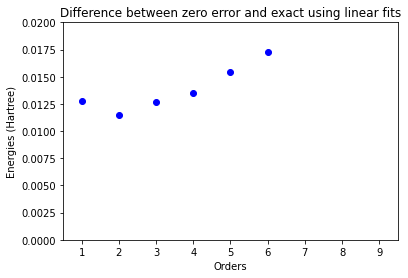

In [58]:

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
scales = [1,2,3,4,5,6,7,8,9,10]
lin_funcs = []
for i in range(2,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 1)
    print(scales[:i])
    p = np.poly1d(param)
    lin_funcs.append(p)
x = np.linspace(-0.5, 10.5, 50)
lin_diff = []
for f in lin_funcs: 
    lin_diff.append(f(0) -exact_energies[0])

plt.plot([1,2,3,4,5,6,7,8,9], lin_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using linear fits')
plt.show()

[1, 2, 3]
[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


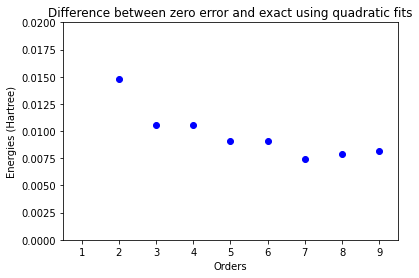

In [55]:

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
scales = [1,2,3,4,5,6,7,8,9,10]
quad_funcs = []
for i in range(3,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 2)
    print(scales[:i])
    p = np.poly1d(param)
    quad_funcs.append(p)
x = np.linspace(-0.5, 10.5, 50)
quad_diff = []
for f in quad_funcs: 
    quad_diff.append(f(0) -exact_energies[0])

plt.plot([2,3,4,5,6,7,8,9], quad_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using quadratic fits')
plt.show()

[1, 2, 3, 4]
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


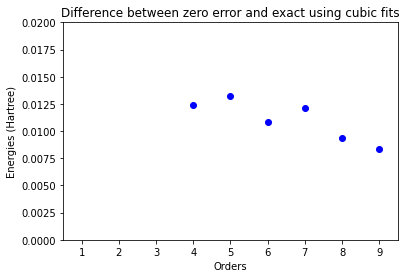

In [56]:

from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
scales = [1,2,3,4,5,6,7,8,9,10]
cub_funcs = []
for i in range(4,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 3)
    print(scales[:i])
    p = np.poly1d(param)
    cub_funcs.append(p)
cub_diff = []
for f in cub_funcs: 
    cub_diff.append(f(0) -exact_energies[0])

plt.plot([3,4,5,6,7,8,9], cub_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using cubic fits')
plt.show()

[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


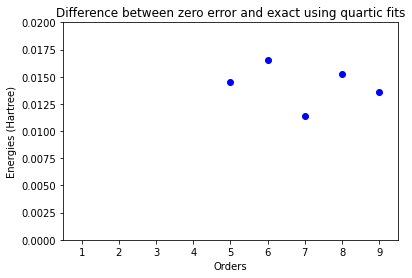

In [57]:
quar_funcs = []
for i in range(5,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 4)
    print(scales[:i])
    p = np.poly1d(param)
    quar_funcs.append(p)
quar_diff = []
for f in quar_funcs: 
    quar_diff.append(f(0) -exact_energies[0])

plt.plot([4,5,6,7,8,9], quar_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using quartic fits')
plt.show()

[1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


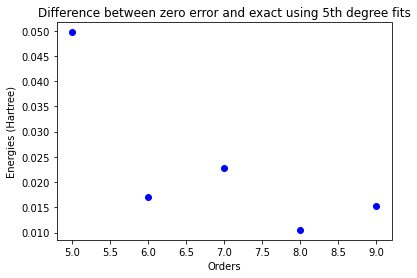

In [60]:
quin_funcs = []
for i in range(6,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 5)
    print(scales[:i])
    p = np.poly1d(param)
    quin_funcs.append(p)
quin_diff = []
for f in quin_funcs: 
    quin_diff.append(f(0) -exact_energies[0])

plt.plot([5,6,7,8,9], quin_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
#plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using 5th degree fits')
plt.show()

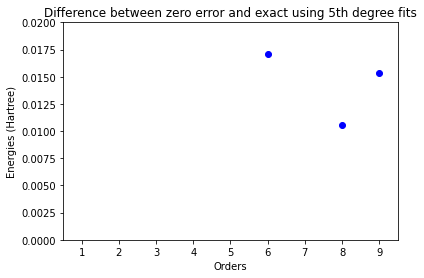

In [61]:
plt.plot([5,6,7,8,9], quin_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using 5th degree fits')
plt.show()

[1, 2, 3, 4, 5, 6, 7]
[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


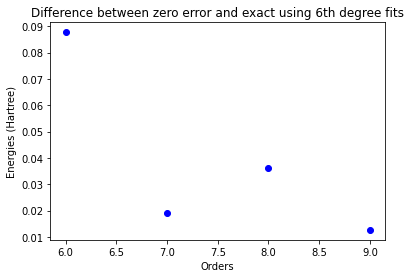

In [62]:
sex_funcs = []
for i in range(7,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 6)
    print(scales[:i])
    p = np.poly1d(param)
    sex_funcs.append(p)
sex_diff = []
for f in sex_funcs: 
    sex_diff.append(f(0) -exact_energies[0])

plt.plot([6,7,8,9], sex_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
#plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using 6th degree fits')
plt.show()

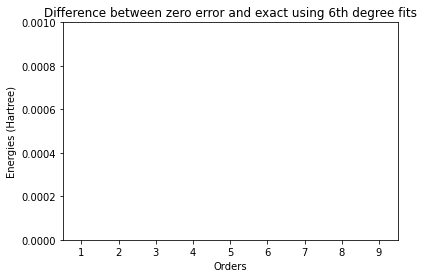

In [63]:
plt.plot([6,7,8,9], sex_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
plt.axis([0.5,9.5, 0, 0.001])
plt.title('Difference between zero error and exact using 6th degree fits')
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


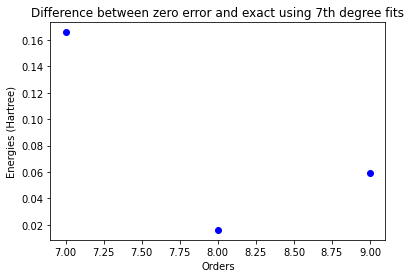

In [64]:
sept_funcs = []
for i in range(8,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 7)
    print(scales[:i])
    p = np.poly1d(param)
    sept_funcs.append(p)
sept_diff = []
for f in sept_funcs: 
    sept_diff.append(f(0) -exact_energies[0])

plt.plot([7,8,9], sept_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
#plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using 7th degree fits')
plt.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


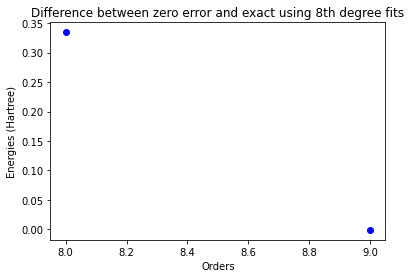

In [65]:
oct_funcs = []
for i in range(9,11): 
    param = np.polyfit(scales[:i], vqe_mean[:i], 8)
    print(scales[:i])
    p = np.poly1d(param)
    oct_funcs.append(p)
oct_diff = []
for f in oct_funcs: 
    oct_diff.append(f(0) -exact_energies[0])

plt.plot([8,9], oct_diff,'bo')
plt.xlabel('Orders')
plt.ylabel('Energies (Hartree)')
#plt.axis([0.5,9.5, 0, 0.02])
plt.title('Difference between zero error and exact using 8th degree fits')
plt.show()